In [1]:
import os
import json, urllib, requests
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import pylab as plt
import matplotlib.dates as mdates
from pandas.io.json import json_normalize
epoch = datetime.datetime.utcfromtimestamp(0)
def unix_time_millis(dt):
    return int((dt - epoch).total_seconds() * 1000.0)

## Getting all events for a release

In [2]:
def get_events(issue_id, token, days=90, limit=None):
    cutoff_cursor = unix_time_millis(datetime.datetime.now() - datetime.timedelta(days=days))
    
    all_events = []
    results = True
    url = f"https://sentry.io/api/0/issues/{issue_id}/events/?query="
    counter = 0
    while limit is None or counter < limit:
        print(url)
        r = requests.get(url, 
                         headers={'Authorization': 'Bearer %s' % token})
        
        try:
            events_json = r.json()
        except:
            print(r)
            raise
            
        for event in events_json:
            # print(event['eventID'], event['title'], event['culprit'], event['event.type'])
            for tag in event['tags']:
                if tag['key'] == 'environment' and tag['value'] in 'prod':
                    all_events.append(event)
                    
        cursor = r.headers['Link'].split(',')[1].split(';')[3].split('=')[1].replace('"', '')        
        results_str = r.headers['Link'].split(',')[1].split(';')[2].split('=')[1].replace('"', '')
        # print(results_str)
        results = results_str.strip() == 'true'
        # print(r.headers['Link'])
        new_url = f"https://sentry.io/api/0/issues/{issue_id}/events/?cursor={cursor}&query="
        # print(cursor)
        if not results:
            break
        url = new_url
        counter += 1
        
    for e in all_events:
        e['tags'] = dict([(a['key'], a['value']) for a in e['tags']])
    
    all_events_df =json_normalize(all_events)
    
    all_events_df.dateCreated = pd.to_datetime(all_events_df.dateCreated)
    
    all_events_df['date_minus_time'] = all_events_df["dateCreated"].apply( lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
    all_events_df['date_minus_time'] = all_events_df['date_minus_time'] - pd.to_timedelta(7, unit='d')
    all_events_df.set_index(all_events_df["date_minus_time"], inplace=True)
    
    return all_events_df

In [3]:
all_successful_events_df = get_events("758615130", os.environ['SENTRY_TOKEN'])

https://sentry.io/api/0/issues/758615130/events/?query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:100:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:200:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:300:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:400:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:500:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:600:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:700:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:800:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:900:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:1000:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:1100:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:1200:0&query=
https://sentry.io/api/0/issues/758615130/events/?cursor=0:1300:0&query=
https://sentry.io

In [4]:
all_started_events_df = get_events("540334560", os.environ['SENTRY_TOKEN'])

https://sentry.io/api/0/issues/540334560/events/?query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:100:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:200:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:300:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:400:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:500:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:600:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:700:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:800:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:900:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:1000:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:1100:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:1200:0&query=
https://sentry.io/api/0/issues/540334560/events/?cursor=0:1300:0&query=
https://sentry.io

## Filtering dataframes

In [5]:
unique_success = all_successful_events_df.drop_duplicates(subset=['tags.run_uuid'])
unique_started = all_started_events_df.drop_duplicates(subset=['tags.run_uuid'])
unique_started_success = unique_success.loc[unique_success['tags.run_uuid'].isin(unique_started['tags.run_uuid'])]

versions = sorted(unique_started['tags.release'].unique())[-12:]

In [6]:
group_success = unique_success.groupby([unique_success['date_minus_time'].dt.year, unique_success['date_minus_time'].dt.week])['id'].count()
grouped_started = unique_started.groupby([unique_started['date_minus_time'].dt.year, unique_started['date_minus_time'].dt.week])['id'].count()
grouped_started_success = unique_started_success.groupby([unique_started_success['date_minus_time'].dt.year, unique_started_success['date_minus_time'].dt.week])['id'].count()

In [7]:
versions_success = {}
versions_started = {}

for version in versions:
    ver_suc = unique_started_success[unique_started_success['tags.release'] == version]
    ver_sta = unique_started[unique_started['tags.release'] == version]
    
    versions_success[version] = ver_suc.groupby([ver_suc['date_minus_time'].dt.year, ver_suc['date_minus_time'].dt.week])['id'].count()
    versions_started[version] = ver_sta.groupby([ver_sta['date_minus_time'].dt.year, ver_sta['date_minus_time'].dt.week])['id'].count()

versions_success = pd.DataFrame(versions_success)
versions_started = pd.DataFrame(versions_started)


## Successful runs per week

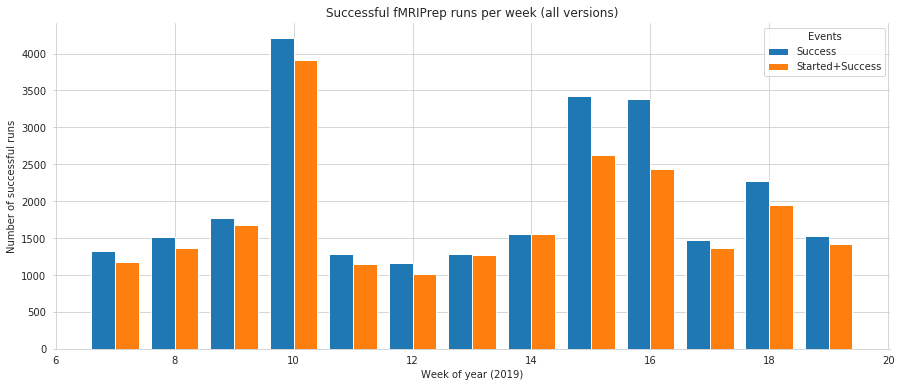

In [8]:
sns.set_style("whitegrid")
fig,ax = plt.subplots(figsize=(15, 6))
indexes = group_success.index.levels[1][:-1]
ax.bar(indexes - 0.2, group_success.values[:-1], width=0.4, label='Success')
ax.bar(indexes + 0.2, grouped_started_success.values[:-1], width=0.4,
       label='Started+Success')

plt.ylabel("Number of successful runs")
plt.xlabel("Week of year (2019)")
plt.title("Successful fMRIPrep runs per week (all versions)")
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('successful_weekly_abs.png', dpi=300, bbox_inches='tight')

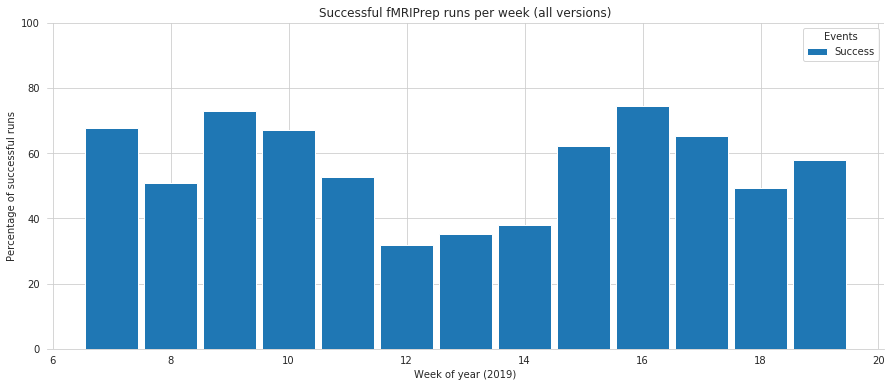

In [9]:
sns.set_style("whitegrid")
fig,ax = plt.subplots(figsize=(15, 6))
ax.bar(indexes, (grouped_started_success.values[:-1] / grouped_started.values[:-1]) * 100,
       width=0.9, label='Success')

plt.ylabel("Percentage of successful runs")
plt.xlabel("Week of year (2019)")
plt.title("Successful fMRIPrep runs per week (all versions)")
ax.set_ylim((0,100))
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('successful_weekly_rel.png', dpi=300, bbox_inches='tight')

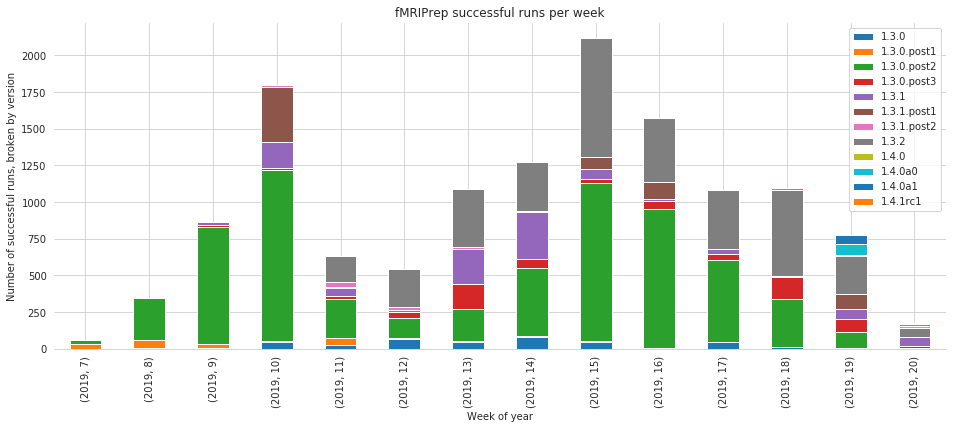

In [10]:
fig,ax = plt.subplots(figsize=(16,6))
ax = versions_success.plot.bar(stacked=True, ax=ax)

sns.despine(left=True)
plt.ylabel("Number of successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('version_successful_weekly_abs.png', dpi=300, bbox_inches='tight')

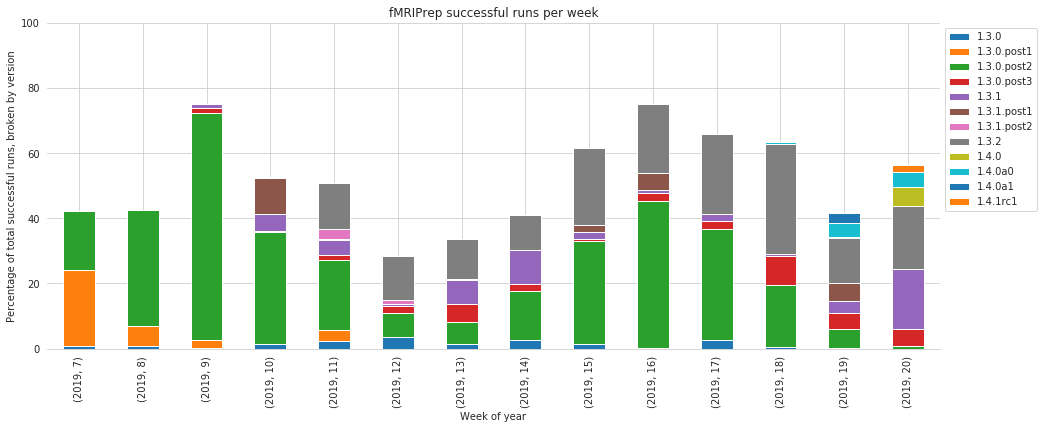

In [11]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.T / versions_started.sum(axis=1)).T * 100).plot.bar(stacked=True, ax=ax)

sns.despine(left=True)
ax.set_ylim((0,100))
plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('version_successful_weekly_rel_total.png', dpi=300, bbox_inches='tight')

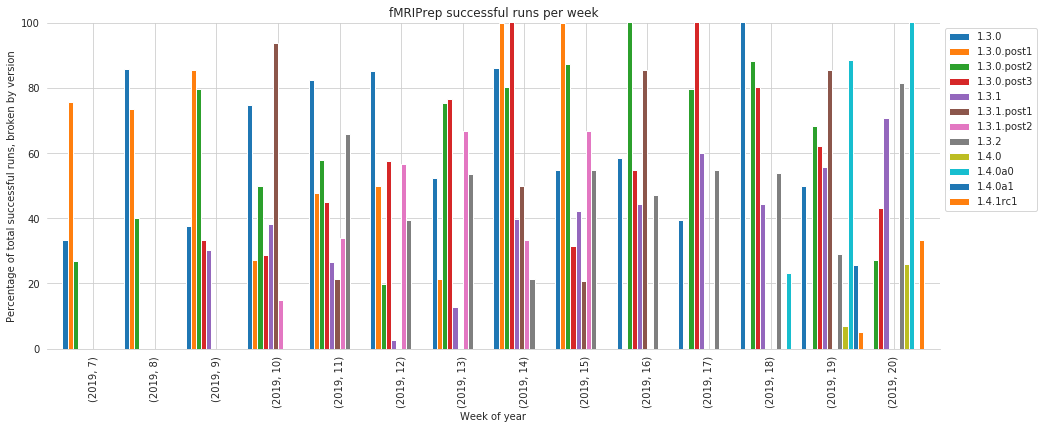

In [12]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success / versions_started) * 100).plot.bar(ax=ax, width=1.0)

sns.despine(left=True)
ax.set_ylim((0,100))

plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('version_successful_weekly_rel_broken.png', dpi=300, bbox_inches='tight')